In [1]:
%load_ext autoreload
%autoreload 2

# After following the installation (or building from source) instructions,
# you should be able to import jaxquantum without having to add it to
# your path explicitly. 

In [2]:
import jaxquantum as jqt
from jax import jit
import jax.numpy as jnp
import matplotlib.pyplot as plt


omega_q = 5.0 #GHz
Omega = .1
g_state = jqt.tensor(jqt.basis(2,0), jqt.basis(2,0))
g_state_dm = jqt.ket2dm(g_state)
ts = jnp.linspace(0,5*jnp.pi/Omega,101)
c_ops = jnp.array([0.1*jqt.tensor(jqt.sigmam(),jqt.identity(N=2))])

sz0 = jqt.tensor(jqt.sigmaz(), jqt.identity(N=2))

@jit
def Ht(t):
    H0 = omega_q/2.0*(jqt.tensor(jqt.sigmaz(),jqt.identity(N=2)) + jqt.tensor(jqt.identity(N=2), jqt.sigmaz()))
    H1 = Omega*jnp.cos((omega_q)*t)*(jqt.tensor(jqt.sigmax(), jqt.identity(N=2)) + jqt.tensor(jqt.identity(N=2), jqt.sigmax()))
    return H0 + H1

# Schroedinger's Equation

In [3]:
%timeit -n1 -r1 jqt.sesolve(g_state, ts,  Ht=Ht) 
%timeit jqt.sesolve(g_state, ts, Ht=Ht) 

941 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
3.41 ms ± 7.67 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [4]:
states = jqt.sesolve(g_state, ts,  Ht=Ht) 
szt = jnp.real(jqt.calc_expect(sz0, states))

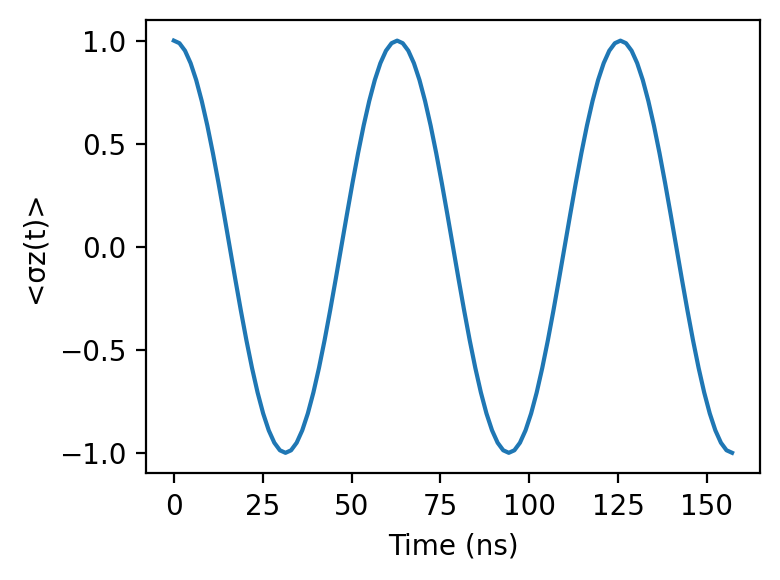

In [5]:
fig, ax = plt.subplots(1, dpi=200, figsize=(4,3))
ax.plot(ts, szt)
ax.set_xlabel("Time (ns)")
ax.set_ylabel("<σz(t)>")
fig.tight_layout()

# Master Equation in Lindbladian Form

In [6]:
%timeit -n1 -r1 jqt.mesolve(g_state_dm, ts, c_ops=c_ops, Ht=Ht) 
%timeit jqt.mesolve(g_state_dm, ts, c_ops=c_ops, Ht=Ht) 

1.18 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
33.2 ms ± 1.63 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [7]:
states = jqt.mesolve(g_state_dm, ts, c_ops=c_ops, Ht=Ht) 
szt = jnp.real(jqt.calc_expect(sz0, states))

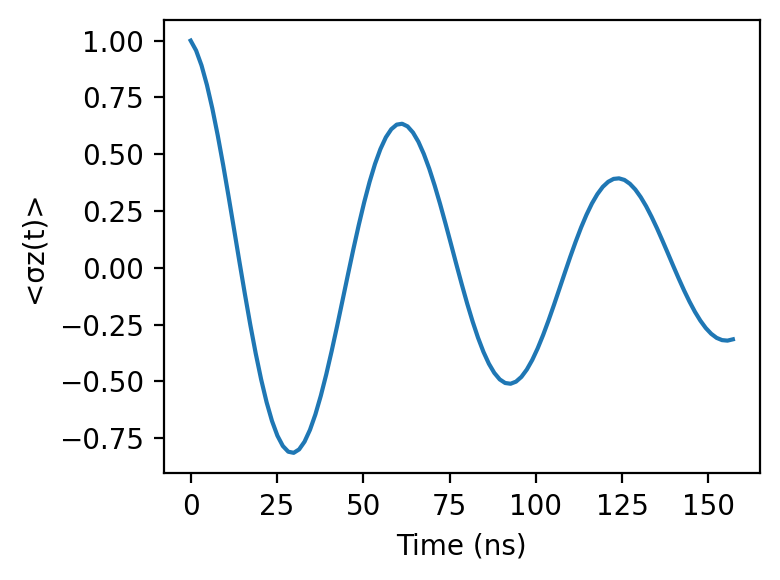

In [8]:
fig, ax = plt.subplots(1, dpi=200, figsize=(4,3))
ax.plot(ts, szt)
ax.set_xlabel("Time (ns)")
ax.set_ylabel("<σz(t)>")
fig.tight_layout()

# Auto-Diff

In [9]:
from jax import grad

@jit
def test_grad(a):
    states = jqt.mesolve(g_state_dm, ts, c_ops=a*c_ops, Ht=Ht) 
    return jnp.real(states[-1][0,0])

%timeit -n1 -r1 grad(test_grad)(1.0)
%timeit grad(test_grad)(1.0)

10.2 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
311 ms ± 118 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
